In [20]:
%pylab inline
import numpy as np
import torch
import os
import pandas as pd

from torch import nn
from torch import optim
from torch.nn import functional as F
from torch import autograd
from torch.autograd import Variable
import nibabel as nib
from torch.utils.data.dataset import Dataset
from torch.utils.data import dataloader

import matplotlib.pyplot as plt
from nilearn import plotting
from ADNI_dataset import *
from BRATS_dataset import *
from ATLAS_dataset import *

import pytorch_ssim
from ipdb import set_trace

Populating the interactive namespace from numpy and matplotlib


/usr/local/miniconda3/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['Generator', 'mean', 'resize', 'gamma', 'beta', 'plotting', 'disp']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


# Configuration

In [21]:
# used to store the MMD ans MS-SSIM
try:
    os.mkdir('./test_data')
except FileExistsError:
    pass
gpu = True
workers = 4
BATCH_SIZE = 8

Use_BRATS = False
Use_ATLAS = False

In [22]:
trainset = ADNIdataset(augmentation=True)
train_loader = torch.utils.data.DataLoader(trainset,batch_size=BATCH_SIZE,
                                          shuffle=True,num_workers=workers)
#'flair' or 't2' or 't1ce'
# trainset = BRATSdataset(imgtype='flair')
# train_loader = torch.utils.data.DataLoader(trainset,batch_size = BATCH_SIZE, shuffle=True,
#                                                num_workers=workers)

# trainset = ATLASdataset(augmentation=True)
# train_loader = torch.utils.data.DataLoader(trainset,batch_size=BATCH_SIZE,
#                                           shuffle=True,num_workers=workers)

def inf_train_gen(data_loader):
    while True:
        for _,images in enumerate(data_loader):
            yield images
gen_load = inf_train_gen(train_loader)

## Pre-trained Generator Load

In [33]:
#-------------------------------------------
#Choose the Model you want!
# from Model_alphaWGAN import Generator
# from Model_alphaGAN import Generator
from Model_VAEGAN import Generator
# from Model_WGAN import Generator
#-------------------------------------------

G = Generator(noise=1000).cuda()
#-----------------------
#Load Pre-trained model
#-----------------------

#------------Trained Model of ATLAS dataset---------------------
# G.load_state_dict(torch.load('./trained/Ours_G.pth')) #Ours (Alpha-WGAN-GP)
# G.load_state_dict(torch.load('./trained/G_VG_iter24552.pth')) #VAE-GAN
# G.load_state_dict(torch.load('./checkpoint/Alpha_G.pth')) #Alpha-GAN
G.load_state_dict(torch.load('./checkpoint/G_W_iter44500.pth')) #WGAN-GP

#------------Trained Model of ATLAS dataset---------------------
# G.load_state_dict(torch.load('./checkpoint/Ours_at_G.pth'))

#------------Trained Models of BRATS dataset---------------------
# G.load_state_dict(torch.load('./checkpoint/Ours_fl_G.pth'))
# G.load_state_dict(torch.load('./checkpoint/Ours_t2_G.pth'))

Fake Image - slice series visualization

You can change the axis (x , y , z ) by changing  display_mode = 'x' / 'y' / 'z'

/usr/local/miniconda3/lib/python3.7/site-packages/torch/nn/functional.py:2351: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/usr/local/miniconda3/lib/python3.7/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


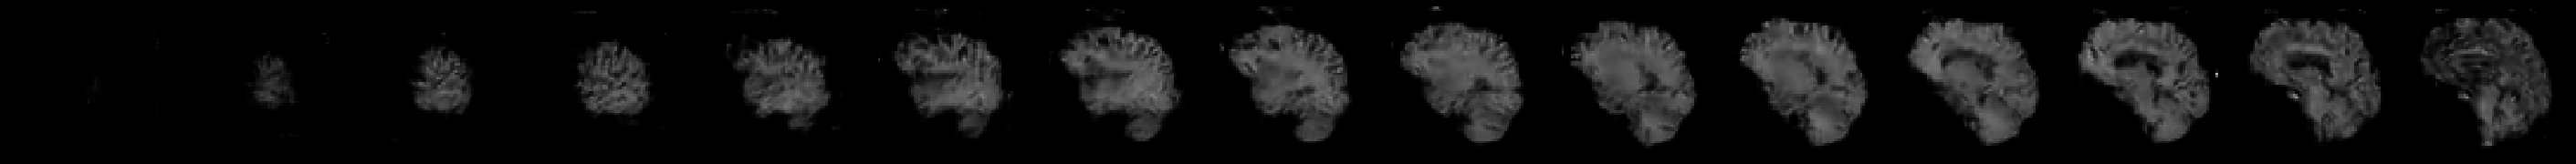

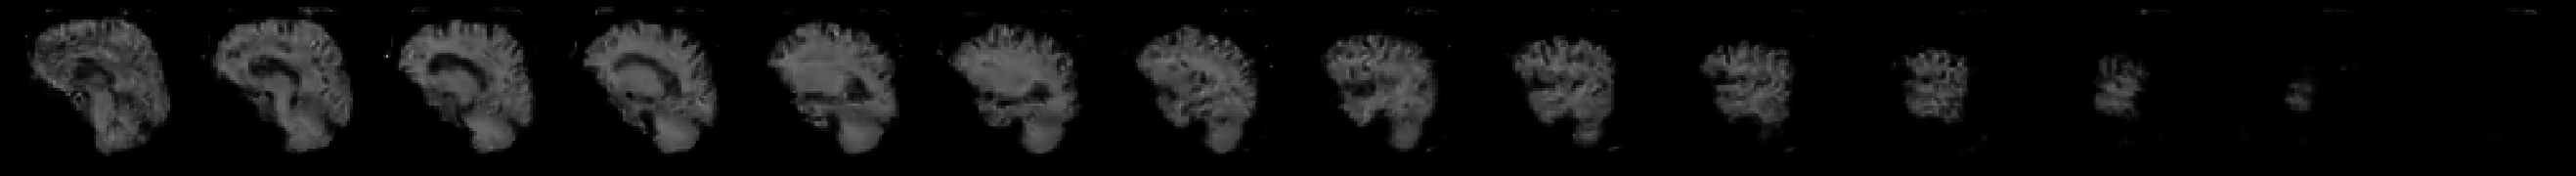

In [34]:
Show_color = False

noise = torch.randn(1, 1000).cuda()
fake_image = G(noise)
featmask = np.squeeze(fake_image[0].data.cpu().numpy())
featmask = nib.Nifti1Image(featmask,affine = np.eye(4))

arr1 = [4,6,8,10,12,14,16,18,20,22,24,26,28,30,32]
arr2 = [34,36,38,40,42,44,46,48,50,52,54,56,58,60]
if Show_color:
    disp = plotting.plot_img(featmask,cut_coords=arr1,draw_cross=False,annotate=False,black_bg=True,display_mode='x')
    # disp.annotate(size=25,left_right=False,positions=True)
    plotting.show()
    disp=plotting.plot_img(featmask,cut_coords=arr2,draw_cross=False,annotate=False,black_bg=True,display_mode='x')
    # disp.annotate(size=25,left_right=False)
    plotting.show()
else:
    disp = plotting.plot_anat(featmask,cut_coords=arr1,draw_cross=False,annotate=False,black_bg=True,display_mode='x')
    plotting.show()
    # disp.annotate(size=25,left_right=False)
    disp=plotting.plot_anat(featmask,cut_coords=arr2,draw_cross=False,annotate=False,black_bg=True,display_mode='x')
    # disp.annotate(size=25,left_right=False)
    plotting.show()

Fake Image - Center cut slices Visualization

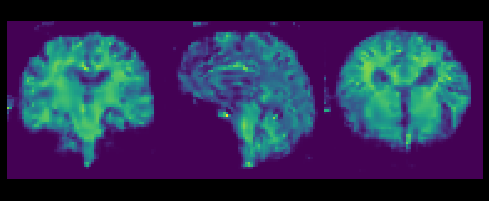

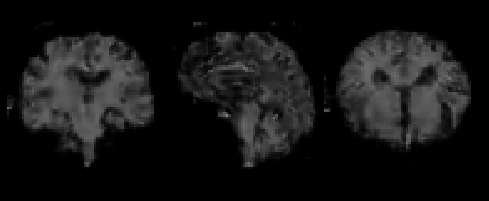

In [35]:
noise = Variable(torch.randn((1, 1000)).cuda())
# fake_image = G(noise)
featmask = np.squeeze(fake_image[0].data.cpu().numpy())
featmask = nib.Nifti1Image(featmask,affine = np.eye(4))
plotting.plot_img(featmask,cut_coords=(32,32,32),draw_cross=False,annotate=False,black_bg=True)
plotting.plot_anat(featmask,cut_coords=(32,32,32),draw_cross=False,annotate=False,black_bg=True)
plotting.show()

Real Image - Slice series visualization

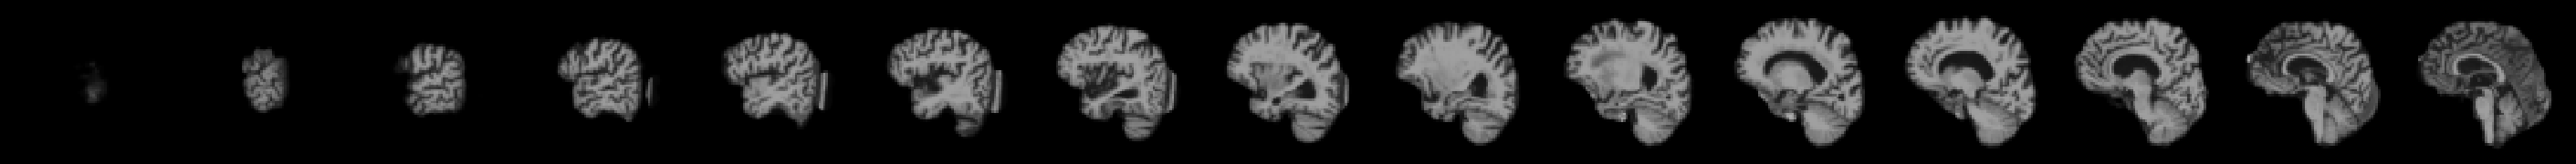

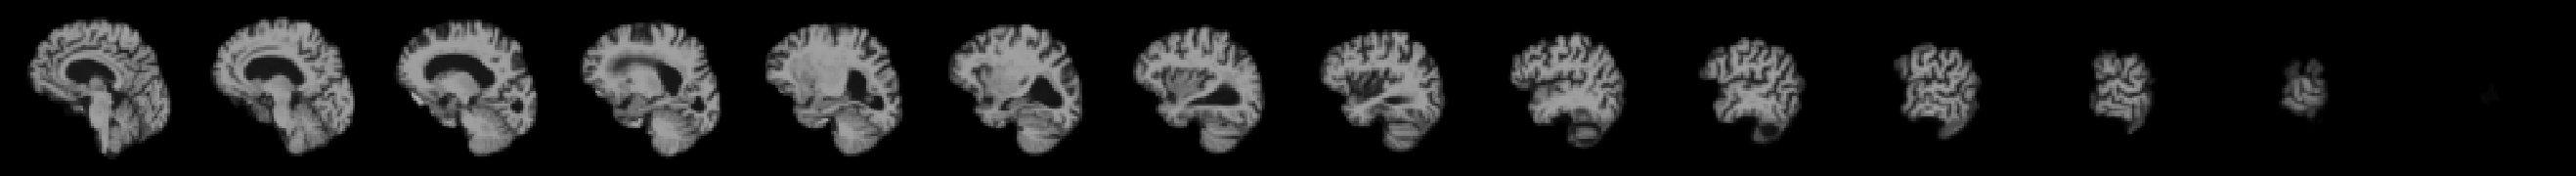

In [36]:
Show_color = False

image = gen_load.__next__()
featmask = np.squeeze(image[0].data.cpu().numpy())
featmask = nib.Nifti1Image(featmask,affine = np.eye(4))
arr1 = [4,6,8,10,12,14,16,18,20,22,24,26,28,30,32]
arr2 = [34,36,38,40,42,44,46,48,50,52,54,56,58,60]

if Show_color:
    disp = plotting.plot_img(featmask,cut_coords=arr1,draw_cross=False,annotate=False,black_bg=True,display_mode='x')
    # disp.annotate(size=25,left_right=False,positions=True)
    plotting.show()
    disp=plotting.plot_img(featmask,cut_coords=arr2,draw_cross=False,annotate=False,black_bg=True,display_mode='x')
    # disp.annotate(size=25,left_right=False)
    plotting.show()
else:
    disp = plotting.plot_anat(featmask,cut_coords=arr1,draw_cross=False,annotate=False,black_bg=True,display_mode='x')
    plotting.show()
    # disp.annotate(size=25,left_right=False)
    disp=plotting.plot_anat(featmask,cut_coords=arr2,draw_cross=False,annotate=False,black_bg=True,display_mode='x')
    # disp.annotate(size=25,left_right=False)
    plotting.show()

# MS-SSIM Calculation

In [37]:
# sum_ssim = 0
# for k in range(20):
#     for i,dat in enumerate(train_loader):
#         if len(dat)!=2:
#             break
#         img1 = dat[0]
#         img2 = dat[1]

#         msssim = pytorch_ssim.msssim_3d(img1,img2)
#         sum_ssim = sum_ssim+msssim
#     print(sum_ssim/((k+1)*(i+1)))

In [38]:
sum_ssim = 0
for i in range(1000):
    noise = Variable(torch.randn((2, 1000)).cuda())
    fake_image = G(noise)

    img1 = fake_image[0]
    img2 = fake_image[1]

    msssim = pytorch_ssim.msssim_3d(img1,img2)
    sum_ssim = sum_ssim+msssim
    if i % 100 == 0:
        print(sum_ssim/1000)


tensor(0.0009, device='cuda:0')


/usr/local/miniconda3/lib/python3.7/site-packages/torch/nn/functional.py:2351: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/usr/local/miniconda3/lib/python3.7/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


tensor(0.0981, device='cuda:0')
tensor(0.1953, device='cuda:0')
tensor(0.2931, device='cuda:0')
tensor(0.3903, device='cuda:0')
tensor(0.4873, device='cuda:0')
tensor(0.5847, device='cuda:0')
tensor(0.6822, device='cuda:0')
tensor(0.7797, device='cuda:0')
tensor(0.8771, device='cuda:0')


# Maximum-Mean Discrepancy Score

In [39]:
# read csv if exists
if os.path.exists('./test_data/mmd.csv'):
    # get the latest index
    df = pd.read_csv('./test_data/mmd.csv')
    start = int(df.iloc[-1]['index'])
else:
    df = pd.DataFrame({'index': [], 'mmd_score': []})
    start = 0 

for p in G.parameters():
    p.requires_grad = False
for s in range(start, 100):
    distmean = 0.0
    for i,(y) in enumerate(train_loader):
        y = Variable(y).cuda()
        noise = Variable(torch.randn((y.size(0), 1000)).cuda())
        x = G(noise)
        B = y.size(0)
        x = x.view(x.size(0), x.size(2) * x.size(3)*x.size(4))
        y = y.view(y.size(0), y.size(2) * y.size(3)*y.size(4))

        xx, yy, zz = torch.mm(x,x.t()), torch.mm(y,y.t()), torch.mm(x,y.t())

        beta = (1./(B*B))
        gamma = (2./(B*B)) 

        Dist = beta * (torch.sum(xx)+torch.sum(yy)) - gamma * torch.sum(zz)
        distmean += Dist

    mean = (distmean/(i+1)).item()
    print(f'\nCount: {s} Mean: {mean}')
    # write scores to csv
    df = df.append(pd.DataFrame({
        'index': [s],
        'mmd_score': [mean]
    }))
    df.to_csv('./test_data/mmd.csv', index=False)

meanarr = numpy.array(df.iloc[:]['mmd_score'].tolist())
print('Total_mean:'+str(np.mean(meanarr))+' STD:'+str(np.std(meanarr)))

/usr/local/miniconda3/lib/python3.7/site-packages/torch/nn/functional.py:2351: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/usr/local/miniconda3/lib/python3.7/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")



Count: 99 Mean: 2426.47900390625
Total_mean:443.2618500052146 STD:344.098486827886


### calculate mmd

In [40]:
df = pd.read_csv('./test_data/mmd.csv')
mmds = np.array(df.iloc[:]['mmd_score'].to_list())
mmds.mean()

443.2618500052146

### visualize loss

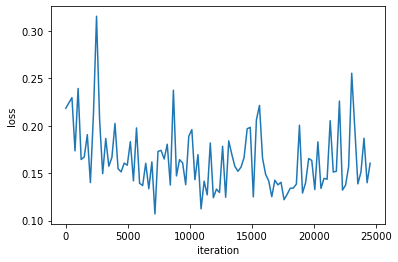

In [31]:
df = pd.read_csv('./trained/VAE_loss.csv')
y_arr = df.iloc[:]['loss:'].to_list()
x_arr = [i * 248 for i in range(len(y_arr))]
plt.xlabel('iteration')
plt.ylabel('loss')
plt.plot(x_arr, y_arr)
plt.show()

In [32]:
ind_arr = df.iloc[:]['index'].to_list()
[(ind_arr[i], x_arr[i]) for i in range(len(ind_arr))]

[('0_247', 0),
 ('1_247', 248),
 ('2_247', 496),
 ('3_247', 744),
 ('4_247', 992),
 ('5_247', 1240),
 ('6_247', 1488),
 ('7_247', 1736),
 ('8_247', 1984),
 ('9_247', 2232),
 ('10_247', 2480),
 ('11_247', 2728),
 ('12_247', 2976),
 ('13_247', 3224),
 ('14_247', 3472),
 ('15_247', 3720),
 ('16_247', 3968),
 ('17_247', 4216),
 ('18_247', 4464),
 ('19_247', 4712),
 ('20_247', 4960),
 ('21_247', 5208),
 ('22_247', 5456),
 ('23_247', 5704),
 ('24_247', 5952),
 ('25_247', 6200),
 ('26_247', 6448),
 ('27_247', 6696),
 ('28_247', 6944),
 ('29_247', 7192),
 ('30_247', 7440),
 ('31_247', 7688),
 ('32_247', 7936),
 ('33_247', 8184),
 ('34_247', 8432),
 ('35_247', 8680),
 ('36_247', 8928),
 ('37_247', 9176),
 ('38_247', 9424),
 ('39_247', 9672),
 ('40_247', 9920),
 ('41_247', 10168),
 ('42_247', 10416),
 ('43_247', 10664),
 ('44_247', 10912),
 ('45_247', 11160),
 ('46_247', 11408),
 ('47_247', 11656),
 ('48_247', 11904),
 ('49_247', 12152),
 ('50_247', 12400),
 ('51_247', 12648),
 ('52_247', 12896)